# Training9

In this notebook file, Sample4 sample will be read from pkl file.

Input(X) and Output(Y) numpy arrays will be created from pandas dataframes.

VGG16 pre-trained model will be load and used.

Pre-trained model's layers except the last CNN block will be set to non-trainable.

Training will be performed in the sections between the last CNN block and the Output layer.

In this way, the experience gained by the model on very large datasets will be used in this classification problem, while the last CNN block will be updated and fine-tuned.

This method is known as [**Fine-Tuning**](https://deeplizard.com/learn/video/5T-iXNNiwIs "deeplizard").

See also [**Transfer Learning and Fine-Tuning**](https://www.tensorflow.org/tutorials/images/transfer_learning "tensorflow").

A keras utils Sequence class will be defined so that operations can be performed on the data to be used during the training.

Performance will be checked with Validation data while training model with Training data.

Accuracy and Loss charts will be drawn according to epoch numbers.

The results obtained by evaluating the model with Test data will be printed.

Based on the Test data, prediction distribution charts will be drawn for each label.

In [1]:
#Libraries are being imported
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('pandas Version: ' + pd.__version__)
print('tensorflow Version: ' + tf.__version__)
print('matplotlib Version: ' + matplotlib.__version__)

numpy Version: 1.22.3
pandas Version: 1.4.3
tensorflow Version: 2.6.0
matplotlib Version: 3.5.2


In [3]:
#GPU will be used for training
myGPU = tf.test.gpu_device_name()
if myGPU:
    print(myGPU)
else:
    print("Error")

/device:GPU:0


In [4]:
#BatchSize and EpochNumber constants are being defined
#A small batchSize value is being chosen to prevent GPU memory problem
#Large batchSize reduce training time while also generally providing better results
BATCH_SIZE = 8
EPOCH_NUMBER = 30

In [5]:
#The Labels are being read from json file
labelDf = pd.read_json('../../Data/RawData/Label/Sample4Label.json')
labelDf

,Name
0,Happy
1,Sad
2,Surprise
3,Neutral


In [6]:
#Sample4 Training data is being read from pkl file
trainingDf = pd.read_pickle("../../Data/Sample4/Training.pkl")
trainingDf

,Label,ImageBGR
0,0,"[[[87, 157, 140], [98, 168, 157], [115, 184, 1..."
1,3,"[[[19, 35, 34], [14, 30, 29], [9, 25, 23], [6,..."
2,3,"[[[58, 69, 89], [53, 63, 83], [46, 53, 73], [3..."
3,2,"[[[191, 191, 191], [189, 189, 189], [188, 188,..."
4,0,"[[[21, 39, 46], [21, 39, 46], [22, 40, 47], [2..."
...,...,...
5680,3,"[[[13, 16, 20], [20, 23, 27], [27, 30, 34], [3..."
5681,1,"[[[175, 177, 171], [171, 172, 168], [188, 191,..."
5682,0,"[[[12, 22, 6], [12, 22, 6], [12, 22, 6], [12, ..."
5683,1,"[[[182, 202, 220], [169, 190, 208], [132, 154,..."


In [7]:
#trainingX is being extracted from trainingDf as wanted shape
#trainingX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

#Converting pixel values to range [-1, 1] in this section is an option
#Doing this once over the entire array now will be save time
#This is not how the conversion will be done because of some memory problems in this project
#Images are of data type np.uint8 when they are in the range [0, 255]
#np.uint8 requires 1 byte memory while np.float32 requires 4 byte and np.float64 requires 8 byte
#See https://www.educba.com/numpy-data-types/
#When np.uint8 data type, images use about 1GB memory
#Even if these pixel values are converted to np.float32 data type, it will need about 4GB of memory
#The computer used for this project has 8GB Ram
#Considering operating system requirements, memory required by the model, etc. 8GB Ram is not enough for this process
#For this reason, this method is not preferred, although it will save time

trainingX = np.array(trainingDf.ImageBGR.values.tolist())
trainingX.shape

(5685, 224, 224, 3)

In [8]:
#trainingY is being extracted from trainingDf as wanted shape
trainingY = np.array(trainingDf.Label.values.tolist()).reshape((-1,1))
trainingY.shape

(5685, 1)

In [9]:
#The dataframe is being deleted because the trainingDf will no longer be needed
del trainingDf

In [10]:
#Sample4 Validation data is being read from pkl file
validationDf = pd.read_pickle("../../Data/Sample4/Validation.pkl")
validationDf

,Label,ImageBGR
0,1,"[[[162, 172, 159], [162, 172, 159], [162, 172,..."
1,0,"[[[252, 250, 250], [252, 250, 250], [252, 250,..."
2,2,"[[[41, 43, 44], [40, 42, 43], [29, 31, 34], [1..."
3,0,"[[[20, 15, 14], [20, 15, 14], [20, 14, 14], [2..."
4,3,"[[[144, 151, 146], [146, 150, 145], [146, 150,..."
...,...,...
943,3,"[[[17, 16, 12], [24, 22, 20], [22, 19, 18], [1..."
944,3,"[[[33, 33, 39], [33, 33, 39], [33, 33, 39], [3..."
945,3,"[[[109, 99, 99], [108, 99, 99], [108, 100, 100..."
946,1,"[[[223, 236, 234], [223, 236, 234], [223, 236,..."


In [11]:
#validationX is being extracted from validationDf as wanted shape
#validationX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

#Converting pixel values to range [-1, 1] in this section is an option
#Doing this once over the entire array now will be save time
#This is not how the conversion will be done because of some memory problems in this project
#Images are of data type np.uint8 when they are in the range [0, 255]
#np.uint8 requires 1 byte memory while np.float32 requires 4 byte and np.float64 requires 8 byte
#See https://www.educba.com/numpy-data-types/
#When np.uint8 data type, images use about 1GB memory
#Even if these pixel values are converted to np.float32 data type, it will need about 4GB of memory
#The computer used for this project has 8GB Ram
#Considering operating system requirements, memory required by the model, etc. 8GB Ram is not enough for this process
#For this reason, this method is not preferred, although it will save time

validationX = np.array(validationDf.ImageBGR.values.tolist())
validationX.shape

(948, 224, 224, 3)

In [12]:
#validationY is being extracted from validationDf as wanted shape
validationY = np.array(validationDf.Label.values.tolist()).reshape((-1,1))
validationY.shape

(948, 1)

In [13]:
#The dataframe is being deleted because the validationDf will no longer be needed
del validationDf

In [14]:
#VGG16 pre-trained model is being loaded
#The original VGG16 model was trained with images with size of (224, 224, 3) 
#in BGR color order and pixel values of [-1, 1] (zero centered) as default
#See https://keras.io/api/applications/vgg/ for more information
#Since images of dataset saved as size of (224, 224, 3) in BGR color order and pixel values of [0, 255]
#dataset will be used by just converting the pixel values to the range [-1, 1]

#Training will be performed in the sections between the last CNN block and the Output layer

model = tf.keras.applications.vgg16.VGG16(include_top = False, input_shape = ((224, 224, 3)))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
#Number of layers of pre-trained model is being calculated except last CNN block
nonTrainablePart = len(model.layers) - 4
nonTrainablePart

15

In [16]:
#Pre-trained model's layers except the last CNN block is being set to non-trainable
for layer in model.layers[:nonTrainablePart]:
    layer.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
#The pre-trained model is being connected to the fully connected layer
#A dropout layer is being added to the the model to prevent overfitting,
#and the model is being completed with the addition of the output layer
model = tf.keras.models.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation = 'relu'),
    tf.keras.layers.Dense(2048, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(labelDf.shape[0], activation = tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 70,301,508
Trainable params: 62,666,244
Non-trainable params: 7,635,264
____________________________________

In [18]:
#Model is being compiled with Adam optimizer
#Adam optimizer is a common used optimizer
#See https://keras.io/api/optimizers/adam/
#See also https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
#SparseCategoricalCrossentropy loss function is being used because of the label format of the data
#SparseCategoricalAccuracy is being used as metric because of the label format of the data
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]
)

In [19]:
#A class inherited from keras utils Sequence is being created
class FitSequence(tf.keras.utils.Sequence):
    
    #Constructor method is being defined
    def __init__(self, image, label, batchSize):
        self.image, self.label = image, label
        self.batchSize = batchSize
        
        #A numpy array for image indexes is being created
        #This array will be used to shuffle the data
        self.index = np.arange(self.image.shape[0])
    
    #__len__ method is being defined
    #This method will be used by the model to show the amount of progress of each epoch
    def __len__(self):
        return int(np.ceil(self.image.shape[0] / float(self.batchSize)))
    
    #__getitem__ method is being defined
    #The model will retrieve the batches it will use during training by calling this method
    #With this method, the data to be used by the model can be manipulated
    def __getitem__(self, idx):
        
        #When the model requests data, the next batch size will be selected based on index array
        indexPart = self.index[idx * self.batchSize : (idx + 1) * self.batchSize]
        
        #Before being sent to the model on demand pixel values will be converted to range [-1, 1]
        #Doing this operation here means that it will be repeated as many epochs for each image and this wastes time
        #This is how the conversion is being done because of some memory problem in this project
        batchX = (self.image[indexPart] / 127.5) - 1
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)
    
    #on_epoch_end method is being defined
    #The model will call this method after each epoch is ended
    def on_epoch_end(self):
        
        #At the end of the epoch, the index array is being shuffled 
        #so that the data in the next epoch is returned in different orders
        np.random.shuffle(self.index)

In [20]:
#model is being trained with EPOCH_NUMBER epochs and BATCH_SIZE batchSize using GPU
with tf.device(myGPU):
    trainingHistory = model.fit(
        FitSequence(trainingX, trainingY, BATCH_SIZE),
        epochs = EPOCH_NUMBER,
        validation_data = FitSequence(validationX, validationY, BATCH_SIZE)
    )

Epoch 1/30
711/711 [==============================] - 507s 669ms/step - loss: 1.4219 - accuracy: 0.2496 - val_loss: 1.3897 - val_accuracy: 0.2300
Epoch 2/30
711/711 [==============================] - 484s 681ms/step - loss: 1.3865 - accuracy: 0.2551 - val_loss: 1.3883 - val_accuracy: 0.2300
Epoch 3/30
711/711 [==============================] - 557s 783ms/step - loss: 1.3865 - accuracy: 0.2489 - val_loss: 1.3885 - val_accuracy: 0.2300
Epoch 4/30
711/711 [==============================] - 523s 736ms/step - loss: 1.3864 - accuracy: 0.2517 - val_loss: 1.3879 - val_accuracy: 0.2300
Epoch 5/30
711/711 [==============================] - 590s 830ms/step - loss: 1.3864 - accuracy: 0.2561 - val_loss: 1.3885 - val_accuracy: 0.2300
Epoch 6/30
711/711 [==============================] - 569s 799ms/step - loss: 1.3864 - accuracy: 0.2545 - val_loss: 1.3883 - val_accuracy: 0.2300
Epoch 7/30
711/711 [==============================] - 570s 801ms/step - loss: 1.3864 - accuracy: 0.2528 - val_loss: 1.3878 -

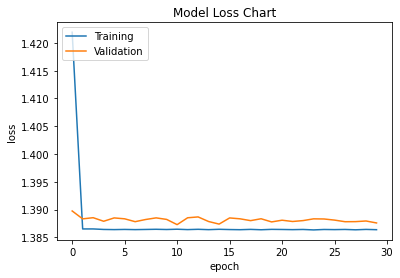

In [21]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['loss'])
plt.plot(trainingHistory.history['val_loss'])

#Chart Tittle
plt.title('Model Loss Chart')

#Chart Labels
plt.ylabel('loss')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

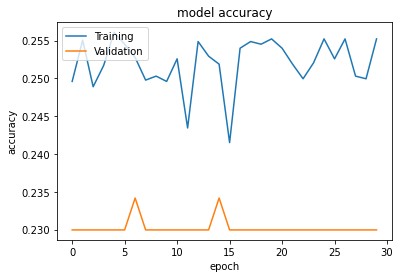

In [22]:
#Accuracy Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['accuracy'])
plt.plot(trainingHistory.history['val_accuracy'])

#Chart Tittle
plt.title('model accuracy')

#Chart Labels
plt.ylabel('accuracy')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

In [23]:
#Sample4 Test data is being read from pkl file
testDf = pd.read_pickle("../../Data/Sample4/Test.pkl")
testDf

,Label,ImageBGR
0,3,"[[[40, 46, 59], [41, 48, 61], [44, 52, 65], [4..."
1,1,"[[[200, 200, 200], [200, 200, 200], [196, 196,..."
2,1,"[[[19, 35, 24], [19, 35, 24], [19, 35, 24], [2..."
3,0,"[[[218, 221, 196], [213, 215, 198], [206, 206,..."
4,3,"[[[75, 93, 86], [76, 93, 86], [79, 96, 89], [8..."
...,...,...
942,1,"[[[244, 215, 171], [246, 217, 175], [243, 215,..."
943,1,"[[[45, 51, 50], [45, 51, 49], [44, 46, 46], [4..."
944,1,"[[[21, 28, 37], [21, 28, 37], [20, 27, 36], [2..."
945,1,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [24]:
#testX is being extracted from testDf as wanted shape
testX = np.array(testDf.ImageBGR.values.tolist())
testX.shape

(947, 224, 224, 3)

In [25]:
#testY is being extracted from testDf as wanted shape
testY = np.array(testDf.Label.values.tolist()).reshape((-1,1))
testY.shape

(947, 1)

In [26]:
#The dataframe is being deleted because the testDf will no longer be needed
del testDf

In [27]:
#Model is being evaluated with test data
#Sequence class is being also used for evaluation to convert test data into the same format as training data
testResult = model.evaluate(FitSequence(testX, testY, BATCH_SIZE))

119/119 [==============================] - 73s 618ms/step - loss: 1.3865 - accuracy: 0.2397


In [28]:
#Test Loss is being Printed
print('Test Loss: ' + str(testResult[0]))

Test Loss: 1.3864667415618896


In [29]:
#Test Accuracy is being Printed
print('Test Accuracy: ' + str(testResult[1]))

Test Accuracy: 0.23970432579517365


In [30]:
#in this block, testX prediction results are being converted in same format as testY
resultList = []
for i in range((testX.shape[0] // 8) + 1):
    #testX is being sliced to Batches
    testSlice = (testX[i * 8: (i + 1) * 8] / 127.5) - 1
    if testSlice.shape[0] > 0:
        #The testX data is sent to the predict function and the results are being stored in the testPredict
        #testPredict results are a numpy array of float type and size of labelDf.shape[0] for each X
        #in this case shape of testPredict is (BATCH_SIZE,  labelDf.shape[0])
        #This is because the deep learning model used returns the results as one-hot encoded
        #See https://en.wikipedia.org/wiki/One-hot 
        #for learn more about one-hot encoding
        #The process applied in this project is a classification
        #One-hot encoding is frequently used in classification processes
        testPredict = model.predict(testSlice)
        for j in range(testPredict.shape[0]):
            #The data stored as one-hot in testPredict is being converted to sparse categorical format like testY 
            #by taking the index of the maximum value with the argmax function
            
            #See also
            #https://medium.com/low-code-for-advanced-data-science/dealing-with-sparse-categorical-variables-in-predictive-modeling-6d9548e22e7f
            resultList.append(testPredict[j].argmax(axis=0))
result = np.array(resultList).reshape((-1,1))
#the shape of result array, same as testY as can be seen
result.shape

(947, 1)

In [31]:
#A kind of confusion matrix and total array for number of each label is being created on this block
#See https://en.wikipedia.org/wiki/Confusion_matrix 
#for more details about confusion matrix
total = np.zeros(labelDf.shape[0], np.int32).reshape((-1,1))
confusionMatrix = np.zeros([labelDf.shape[0], labelDf.shape[0]])
for i in range(result.shape[0]):
    #total counts for each label
    total[testY[i]] += 1
    #rows of confusionMatrix indicates each label and columns indicates predicted labels
    confusionMatrix[testY[i], result[i]] += 1

#To examine, confusionMatrix[1, 1] indicates how many of the data with label 1
#are predicted correctly according to the predict results
#and confusionMatrix[1, 2] shows how many of the data with label 1 were predicted as label 2
confusionMatrix

array([[  0., 244.,   0.,   0.],
       [  0., 227.,   0.,   0.],
       [  0., 241.,   0.,   0.],
       [  0., 235.,   0.,   0.]])

In [32]:
#in this block the rates are being calculated for the confusion matrix
confusionMatrix = confusionMatrix / total
confusionMatrix

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

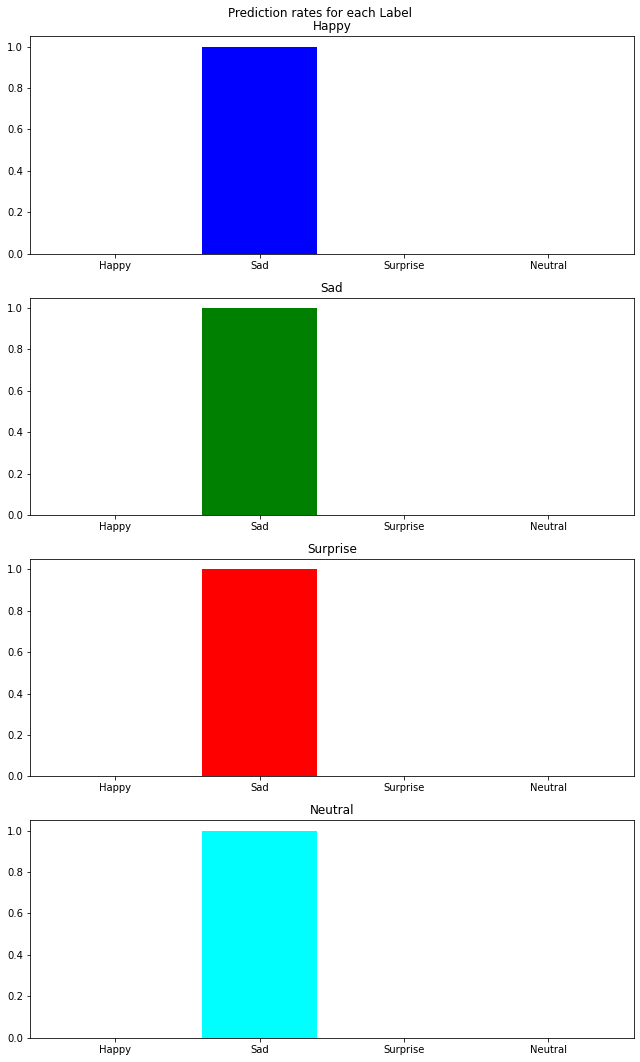

In [33]:
#label list is being created
labels = labelDf.Name.values.tolist()

#length of label list is being calculated
lenLabel = len(labels)

#color list is being defined
colorList = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'olive']

#Figure and Axes are being defined
fig, ax = plt.subplots(lenLabel, figsize=(9, 15))

#Figure title is being defined
fig.suptitle('Prediction rates for each Label')

#Each row of the confusion matrix is added to the charts as separate chart
for i in range(lenLabel):
    ax[i].bar(labels, confusionMatrix[i], color = colorList[(i % len(colorList))])
    ax[i].set_title(labels[i])

#For better format
fig.tight_layout()

#show plot
plt.show()

# Training9 Inference

By looking at the accuracy, loss and prediction distribution charts, it can be seen that learning does not take place.

Looking at the accuracy rates, it can be seen that the value remains constant around 0.4 throughout the training.

Which means the model has not learned enough to have any success even on the Training data, even overfitting did not occur.

However, the accuracy value of around 0.4, which is repeated in the Validation and Test data, is quite high compared to the failure of the training.

The reason for this inconsistency can be explained by the prediction distribution charts.

By looking at the prediction distribution charts, it will be clear that the model produces the same label, which is Happy, for each image.

This is because the data of sample1 sample created by selecting rows with FaceBoxConfidence > 70.0 from the dataset mostly has Happy Labels.

As can be easily estimated, about 0.4 of the data in the sample1 sample are Happy Labeled.

See ../../DataPreparation/Preparation1.ipynb and ../../DataPreparation/Preparation2.ipynb

The case here is a very clear example of the problem of imbalanced datasets.

Performance can be improved by trying Hyperparameter Optimization methods.

See https://en.wikipedia.org/wiki/Hyperparameter_optimization.